## Transfer Learning in CNN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [2]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.Resize((224, 224)),  # Resize images to the size expected by pre-trained models
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [3]:
from torchvision import models

# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

model

c:\Users\shashank.shandilya_d\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\shashank.shandilya_d\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
# Modify the final fully connected layer to match the number of classes in MNIST (10 classes)
model.fc = nn.Linear(model.fc.in_features, 10)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# Freeze all layers except the final layer
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final layer
for param in model.fc.parameters():
    param.requires_grad = True

In [6]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [7]:
# Train the model
num_epochs = 5
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        # Move tensors to the appropriate device (GPU or CPU)
        images, labels = images.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), labels.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


Epoch [1/5], Loss: 0.4059
Epoch [2/5], Loss: 0.1806
Epoch [3/5], Loss: 0.1512
Epoch [4/5], Loss: 0.1338
Epoch [5/5], Loss: 0.1245


In [8]:
# Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), labels.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 96.22%


## Object Detection in CNN

In [10]:
import torch
from torchvision import models, transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

c:\Users\shashank.shandilya_d\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\shashank.shandilya_d\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


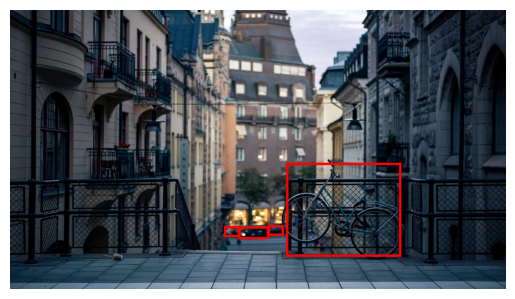

In [11]:
# Step 1: Load the pre-trained Faster R-CNN model
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Step 2: Define the transform to convert the image to a tensor
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to PyTorch tensor
])

# Step 3: Load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path)
    return image, transform(image).unsqueeze(0)  # Add batch dimension

# Step 4: Perform object detection
def detect_objects(image_tensor):
    with torch.no_grad():
        predictions = model(image_tensor)[0]
    return predictions

# Step 5: Draw bounding boxes on the image
def draw_boxes(image, predictions, threshold=0.5):
    draw = ImageDraw.Draw(image)
    
    for i, box in enumerate(predictions['boxes']):
        score = predictions['scores'][i].item()
        if score > threshold:
            box = box.cpu().numpy()
            draw.rectangle(box, outline="red", width=7)
            draw.text((box[0], box[1]), f"{predictions['labels'][i].item()}:{score:.2f}", fill="red")
    
    return image

# Step 6: Visualize the output
def visualize(image_path):
    image, image_tensor = load_image(image_path)
    predictions = detect_objects(image_tensor)
    image_with_boxes = draw_boxes(image, predictions)

    # Display the image with bounding boxes
    plt.imshow(image_with_boxes)
    plt.axis('off')
    plt.show()

# Example usage
image_path = r'C:\Users\shashank.shandilya_d\Desktop\Machine Learning Algorithms\image.jpeg'  # Replace with your image path
visualize(image_path)
